<a href="https://colab.research.google.com/github/jbsdoki/ML_Experimenting/blob/main/LSTM_Stock_Predictor_5_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code heavily references the official TensorFlow website:

https://www.tensorflow.org/addons/overview

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings


warnings.filterwarnings("ignore")

In [3]:
#Create a Pandas dataframe from .csv file
msft_df = pd.read_csv("/content/sample_data/MSFT_Historical_Data.csv")
print(msft_df.shape)

(2515, 6)


In [4]:
#Check for null entries
print(msft_df.isnull())
if msft_df.isnull().values.any():
    print("DataFrame has empty entries")
else:
    print("DataFrame does not have empty entries")

       Date  Close/Last  Volume   Open   High    Low
0     False       False   False  False  False  False
1     False       False   False  False  False  False
2     False       False   False  False  False  False
3     False       False   False  False  False  False
4     False       False   False  False  False  False
...     ...         ...     ...    ...    ...    ...
2510  False       False   False  False  False  False
2511  False       False   False  False  False  False
2512  False       False   False  False  False  False
2513  False       False   False  False  False  False
2514  False       False   False  False  False  False

[2515 rows x 6 columns]
DataFrame does not have empty entries


In [5]:
print(msft_df.sample(10))

            Date Close/Last    Volume      Open       High        Low
1198  04/07/2020    $163.49  62769040  $169.585    $170.00    $163.26
52    10/25/2024    $428.15  16899060   $426.76    $432.52   $426.565
885   07/06/2021    $277.66  31565560   $278.03  $279.3698    $274.30
1701  04/09/2018     $90.77  31508070    $91.04     $93.17     $90.62
1601  08/29/2018    $112.02  20747500   $110.45    $112.03    $110.27
107   08/08/2024    $402.69  20203030   $402.44    $405.86  $399.9407
1623  07/30/2018    $105.37  34495720   $107.19    $107.53    $104.76
30    11/26/2024    $427.99  23458890  $419.585  $429.0414    $418.85
1667  05/25/2018     $98.36  17942630    $98.30     $98.98     $97.86
1420  05/21/2019    $126.90  15293260   $127.43  $127.5273    $126.58


Display data types of dataframe

In [6]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
 2   Volume      2515 non-null   int64 
 3   Open        2515 non-null   object
 4   High        2515 non-null   object
 5   Low         2515 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.0+ KB


Convert strings ($) and dates to usable data

In [7]:
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df['Close/Last'] = msft_df['Close/Last'].str.replace('$', '').astype(float)
msft_df['Open'] = msft_df['Open'].str.replace('$', '').astype(float)
msft_df['High'] = msft_df['High'].str.replace('$', '').astype(float)
msft_df['Low'] = msft_df['Low'].str.replace('$', '').astype(float)

msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
 2   Volume      2515 non-null   int64         
 3   Open        2515 non-null   float64       
 4   High        2515 non-null   float64       
 5   Low         2515 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.0 KB


In [8]:
print(msft_df.sample(5))

           Date  Close/Last    Volume     Open    High      Low
640  2022-06-24      267.70  33923230  261.808  267.98  261.720
1011 2021-01-04      217.69  37130140  222.530  223.00  214.810
1724 2018-03-06       93.32  21884540   94.340   94.49   92.941
2046 2016-11-21       60.86  19638240   60.500   60.97   60.420
161  2024-05-21      429.04  21453260  426.825  432.97  424.850


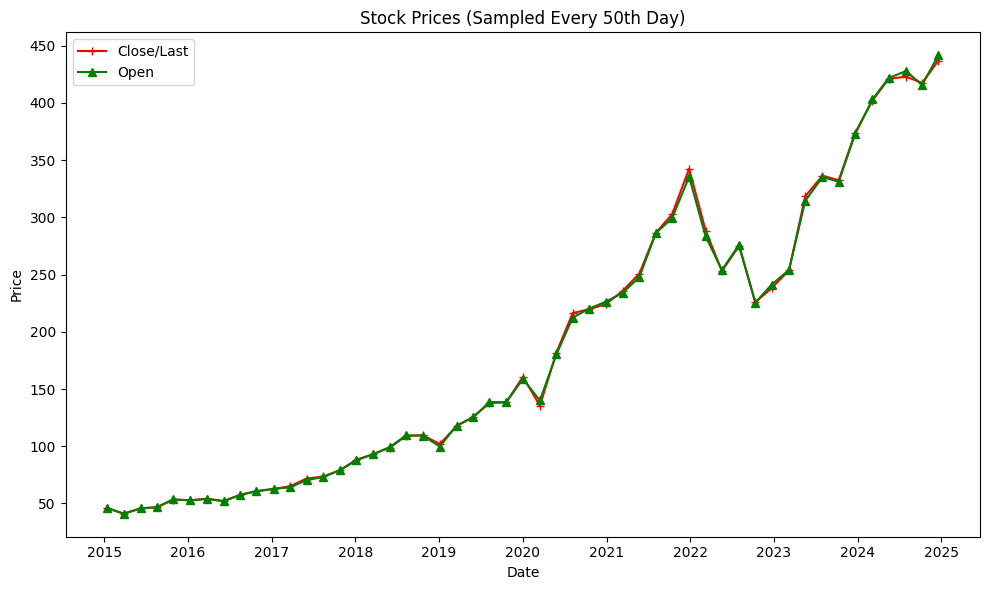

In [9]:
#Reversing order of data so that training is at 80% (Starting from 2013)
dataframe = msft_df.iloc[::-1].reset_index(drop = True)
#Sampling every 50th row of data
sampled_data = dataframe.iloc[::50]

plt.figure(figsize=(10, 6))
plt.plot(sampled_data['Date'], sampled_data['Close/Last'], color="r", label="Close/Last", marker="+")
plt.plot(sampled_data['Date'], sampled_data['Open'], color="g", label="Open", marker="^")

plt.title("Stock Prices (Sampled Every 50th Day)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

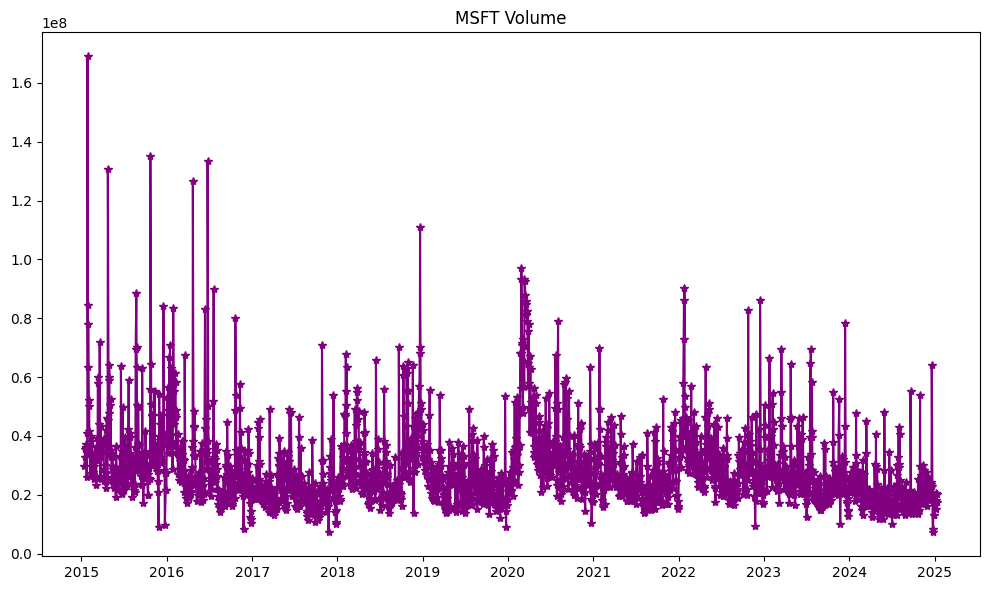

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(dataframe['Date'], dataframe['Volume'], c='purple', marker='*')
plt.title("MSFT Volume")
plt.tight_layout()

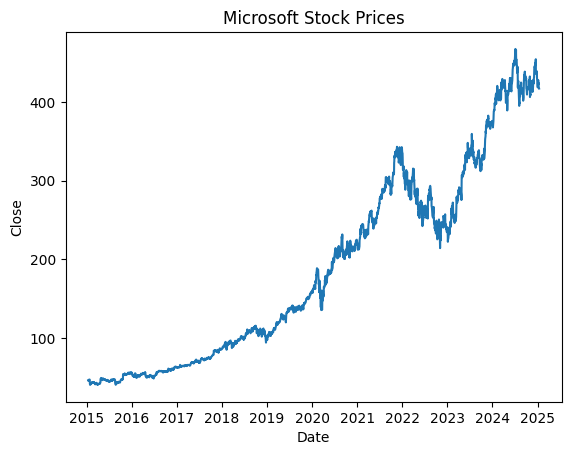

In [11]:
plt.plot(dataframe['Date'],dataframe['Close/Last'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Microsoft Stock Prices")
plt.show()

Using more parameters to train a model can lead to unnecessary complexity and overfitting, and might include data that isn't useful, but to know that you need to test to find what data matters, and what you can ignore


In [12]:
close_data = dataframe[['Close/Last', 'Volume', 'Open', 'High', 'Low']]
close_data.head()
dataset = close_data.values
training = int(np.ceil(len(dataset) * 0.80))

#Scaling all parameters to between 0 and 1, large swings
#in data size can have a negative effect on the model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :] #This is where you decide the dimensions of the data you will feed the model
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, :]) #
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

TensorFlows sequential model takes in data and generates 1 prediction step at a time. If you feed the model data where each datapoint is a day, then the model will create a prediction 1 day into the future

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32, activation='linear'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

#Some basic model choices
MSE loss function is the standard for stocks

Huber loss function is useful when data has huge swings (strange outliers)

adam (Adaptive Moment Estimation) dynamically adjusts learning rates

To use Huber loss function with model:

model.compile(optimizer='adam', loss=tf.keras.losses.Huber())


In [14]:
model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=15)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0119
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013


In [15]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

# predict the testing data
predictions = model.predict(x_test)
predictions = predictions.reshape(-1, 1)
predictions = np.hstack([predictions, np.zeros((predictions.shape[0], dataset.shape[1] - 1))])
predictions = scaler.inverse_transform(predictions)
predictions = predictions[:, 0]

y_test_close = y_test[:, 0]

# evaluation metrics
mse = np.mean(((predictions - y_test_close) ** 2))
print("RMSE", np.sqrt(mse))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE 12.628631473469905


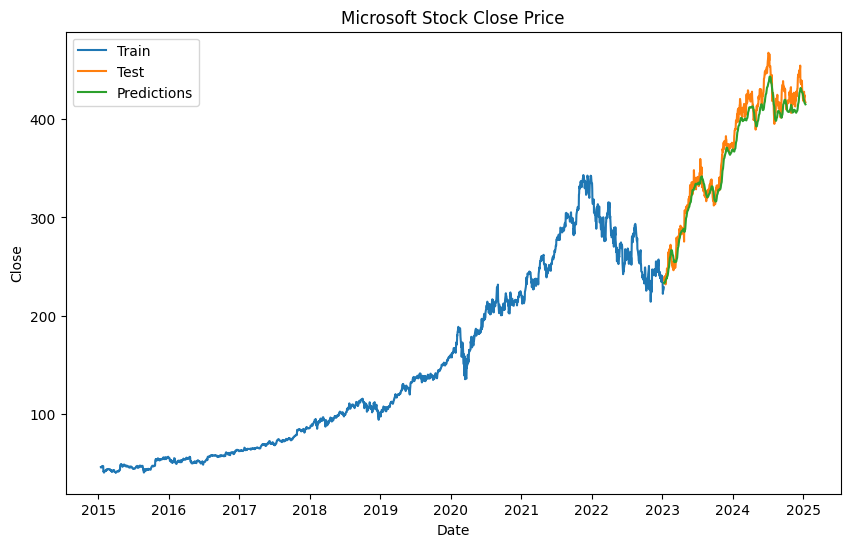

In [16]:
train = dataframe[:training]
test = dataframe[training:]
test['Predictions'] = predictions

plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Close/Last'])
plt.plot(test['Date'], test[['Close/Last', 'Predictions']])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

Now I will attempt to predict the next 60 days of stock movement, whereas earlier we were feeding the model real stock prices, in this instance we will create a feedback loop that uses the models past predictions to create future predictions

In [21]:
# Start with the last 120 days of data
last_360_days = scaled_data[-360:, :]
future_predictions = []

last_date = dataframe['Date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 61)]

#Add noise to prevent overfitting
noise_std_dev = 0.1

# Predict the next 60 days
with tqdm(total=60, desc="Generating Predictions") as pbar:
  for _ in range(60):
    # Reshape for prediction (1 sample, 60 time steps, features)
    x_input = last_360_days.reshape(1, last_360_days.shape[0], last_360_days.shape[1])

    # Predict the next value
    pred = model.predict(x_input, verbose=0)

    #Add noise
    noisy_pred = pred[0, 0] + np.random.normal(0, noise_std_dev * pred[0, 0])

    # Save the prediction
    future_predictions.append(noisy_pred)  # Assuming a single feature prediction

    # Update the last 60 days by appending the prediction
    pred_scaled = np.hstack([pred, np.zeros((1, scaled_data.shape[1] - 1))])  # Pad if multiple features
    last_360_days = np.vstack([last_360_days[1:], pred_scaled])  # Slide window forward

    pbar.update(1)

# Inverse transform the predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = np.hstack([future_predictions, np.zeros((future_predictions.shape[0], scaled_data.shape[1] - 1))])
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions = future_predictions[:, 0]  # Extract the predicted feature

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predictions': future_predictions
})

Generating Predictions: 100%|██████████| 60/60 [00:03<00:00, 16.04it/s]


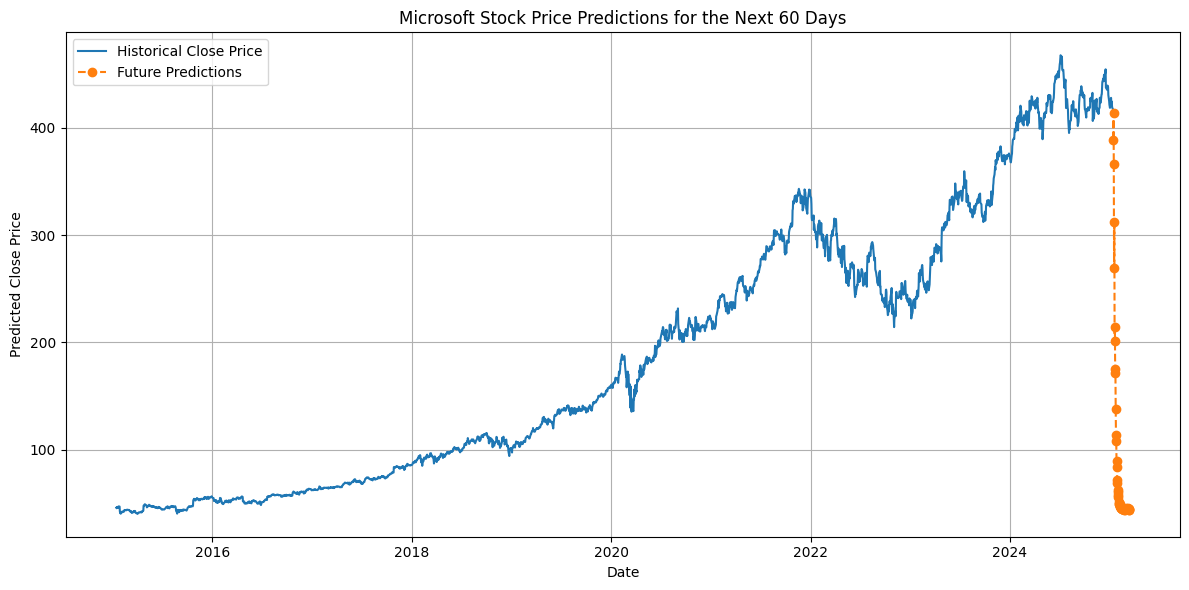

In [22]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(dataframe['Date'], dataframe['Close/Last'], label='Historical Close Price')
plt.plot(future_df['Date'], future_df['Predictions'], label='Future Predictions', linestyle='--', marker='o')
plt.title('Microsoft Stock Price Predictions for the Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

During the first prediction we use real data to predict the next day of the Closing value of the stock, but in this section we are creating the data, small feedback errors in data predicted cause the model to predict a total collapse in value
We need a new model if we are going to predict months into the future!
